Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [1]:
# Importing all the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [2]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")

# generating one row
df = data.sample(frac =.10)


In [3]:
df.count()

InvoiceNo      54191
StockCode      54191
Description    54050
Quantity       54191
InvoiceDate    54191
UnitPrice      54191
CustomerID     40778
Country        54191
dtype: int64

In [4]:
df.describe()

Quantity     UnitPrice    CustomerID
count  54191.000000  54191.000000  40778.000000
mean       9.563950      4.053624  15281.607484
std       59.047961     74.756128   1715.883110
min    -9058.000000 -11062.060000  12347.000000
25%        1.000000      1.250000  13933.250000
50%        3.000000      2.080000  15150.000000
75%       10.000000      4.130000  16791.000000
max     4000.000000   7427.970000  18287.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54191 entries, 519419 to 102209
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54050 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40778 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [6]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      141
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13413
Country            0
dtype: int64

In [7]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.isocalendar().week
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

InvoiceNo StockCode                         Description  Quantity  \
519419    580146     47566                       PARTY BUNTING        10   
524072    580527     21977  PACK OF 60 PINK PAISLEY CAKE CASES         2   
188421    553035     23256         CHILDRENS CUTLERY SPACEBOY          2   
514532    579694     84375       SET OF 20 KIDS COOKIE CUTTERS         1   
449202    575087     21790                  VINTAGE SNAP CARDS         1   

               InvoiceDate  UnitPrice  CustomerID         Country   Sales  \
519419 2011-12-02 10:07:00      10.79         NaN  United Kingdom  107.90   
524072 2011-12-04 15:19:00       0.55     13736.0  United Kingdom    1.10   
188421 2011-05-12 20:13:00       4.15     17337.0  United Kingdom    8.30   
514532 2011-11-30 14:11:00       4.13         NaN  United Kingdom    4.13   
449202 2011-11-08 13:57:00       0.85     16549.0  United Kingdom    0.85   

        Year  Month  Week Year_Month  Hour  Day is_cancelled    weekday  \
519419  2011     12    48    2011-12    10    2           No     Friday   
524072  2011     12    48    2011-12    15    4           No     Sunday   
188421  2011      5    19    2011-05    20   12           No   Thursday   
514532  2011     11    48    2011-11    14   30           No  Wednesday   
449202  2011     11    45    2011-11    13    8           No    Tuesday   

       Quarter       Date  
519419      Q3 2011-12-02  
524072      Q3 2011-12-04  
188421      Q2 2011-05-12  
514532      Q3 2011-11-30  
449202      Q3 2011-11-08

CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

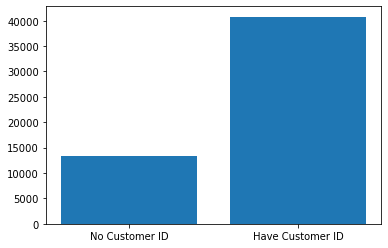

In [8]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])


In [9]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=df.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=df.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

In [10]:
df_=df[df.is_cancelled=='No']
del df

In [11]:
sales_by_date = df_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

In [12]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [13]:
customer_by_month1 = df_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = df_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

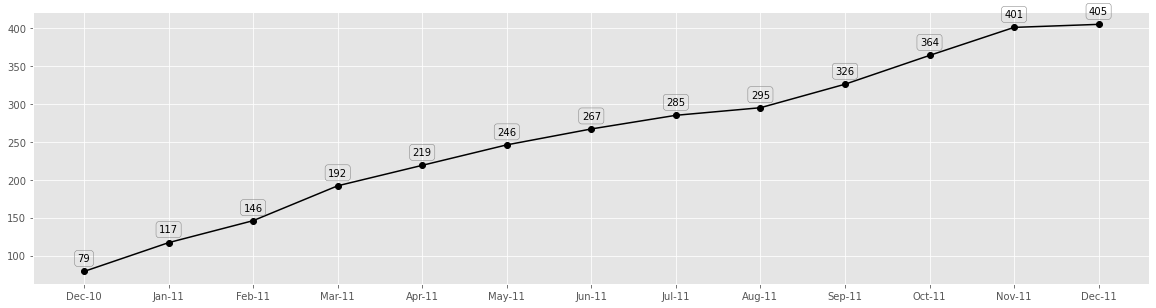

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month


Customer acquisition VS Sales contribution

In [15]:
customer_sales = df_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

Frequent purchasing:
Most of customers made their next purchase after one or two months of first purchase.
There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months.33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

Hourly sales

In [16]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

In [17]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=df_).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

                sum_sq       df          F        PR(>F)
C(Hour)   1.385177e+06     13.0  16.952106  1.070012e-39
Residual  3.347205e+08  53253.0        NaN           NaN


In [18]:
LRFM = df_.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="InvoiceNo", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = df_.groupby('CustomerID')['Date'].max() - df_.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

CustomerID  Frequency  Monetary  Length_of_stay
0     12347.0          7    659.06           365.0
1     12348.0          2    326.16            40.0
2     12349.0          1    129.26             0.0
3     12350.0          1     25.20             0.0
4     12352.0          5    156.98           260.0

#### 3 Dimensional View

In [19]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show()

K Means Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

In [21]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show()

del [error,silhouette,rng,km,lbls,X]

Creating Cluster

In [22]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

Sample vs Silhouette

In [23]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show()


In [24]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show()

Cluster 3 Dimensional View

In [25]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show()

Bivariate view

In [26]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Length_of_stay
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Length of Stay",title='Sales vs Length of Stay'
                  ,width=800,height=500)
fig.show()

In [27]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Frequency
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Frequency",title='Sales vs Frequency'
                  ,width=800,height=500)
fig.show()

### Time Series Forecasting

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [29]:
ds_weekly = df_.groupby(by=['Year','Week'])['Sales'].sum().reset_index()
ds_daily = df_.groupby(by=['Date'])['Sales'].sum().reset_index()

In [30]:
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title='Weekly'):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actual ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Predict',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actual',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Predict',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Forecast',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title=title,yaxis_title="Sales",title=title +' Trend'
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()


Weekly sales

In [31]:
fig = go.Figure(data=[go.Scatter(x=ds_weekly.index,y=ds_weekly.Sales)])
fig.update_layout(xaxis_title="Week",yaxis_title="Sales",title='Weekly Trend',height=400,template='ggplot2')
fig.show()

Daily sales

In [32]:
fig = go.Figure(data=[go.Scatter(x=ds_daily.Date,y=ds_daily.Sales)])
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Trend',height=400,template='ggplot2')
fig.show()


Train-Test split

In [39]:
series_date=ds_daily.Sales
split_time = 250
time_d=np.arange(len(ds_daily))
xtrain_d=series_date[:split_time]
xtest_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',xtrain_d.shape)
print('Testing Set Size ',xtest_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [41]:
series=ds_weekly.Sales
split_time = 45
time=np.arange(len(ds_weekly))
xtrain=series[:split_time]
xtest=series[split_time:]
timeTrain = time[:split_time]
timeTest = time[split_time:]
print('Full Set Size ',series.shape)
print('Training Set Size ',xtrain.shape)
print('Testing Set Size ',xtest.shape)

Full Set Size  (53,)
Training Set Size  (45,)
Testing Set Size  (8,)


In [42]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(xtrain, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   45
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -445.856
Date:                Tue, 29 Dec 2020   AIC                            899.711
Time:                        00:41:11   BIC                            906.848
Sample:                             0   HQIC                           902.358
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0012      0.947      0.001      0.999      -1.854       1.857
ma.L1         -0.6401      0.968     -0.661      0.508      -2.537       1.257
ma.L2         -0.1676      0.663     -0.253      0.8

## Time-series Model -ARIMA

In [43]:
from statsmodels.tsa.arima.model import ARIMA
s_model = ARIMA(endog=xtrain_d , order=(1, 1, 1))
s_model_fit=s_model.fit()
print(s_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2220.401
Date:                Tue, 29 Dec 2020   AIC                           4446.802
Time:                        00:41:15   BIC                           4457.354
Sample:                             0   HQIC                          4451.049
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0721      0.069      1.039      0.299      -0.064       0.208
ma.L1         -0.9271      0.030    -30.435      0.000      -0.987      -0.867
sigma2       3.24e+06   1.13e+05     28.583      0.0

In [44]:
ytrain_pred = model_fit.predict()
ytest_pred = model_fit.predict(start=min(timeTest),end=max(timeTest),dynamic=True)
print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest)**2)))
forecast = model_fit.forecast(20, alpha=0.05)
plot_(t_train = timeTrain,t_test = timeTest,x_train = xtrain,x_test = xtest,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Weekly')

MSE Train : 6619.6099446602275
MSE Test : 10993.432442033933
